# OmniFold with ALEPH Open Data

### Imports

In [1]:
import os

import tensorflow as tf
#tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

import energyflow as ef
import energyflow.archs
import matplotlib.pyplot as plt
import numpy as np
import uproot

import omnifold
import modplot
import ibu

Instructions for updating:
non-resource variables are not supported in the long term


### Plot Style

In [2]:
#plt.rcParams['figure.figsize'] = (4,4)
#plt.rcParams['figure.dpi'] = 120
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['text.usetex'] = True

## Loading the Data

In [5]:
aleph_path = '/callisto/ALEPH'

# load data, currently just get thrust values
thrust_arrs = []
years = [
    #'1992', 
    #'1993', 
    '1994', 
    #'1995'
]
eSels = [
    #'passesNTupleAfterCut',
    #'passesTotalChgEnergyMin', 
    #'passesNTrkMin', 
    #'passesNeuNch',
    #'passesSTheta'
]

for year in years:
    data_file = uproot.open(os.path.join(aleph_path, 'LEP1Data{}_recons_aftercut-MERGED.root'.format(year)))
    event_mask = np.ones(len(data_file['t']['EventNo'])) 
    for eSel in eSels:
        event_mask *= data_file['t'][eSel].array()
    event_mask = np.array(event_mask).astype(bool)
    thrust_arrs.append(1 - data_file['t']['Thrust'].array()[event_mask])
    
# dictionary to hold observable values
nature = {'data_thrusts': np.concatenate(thrust_arrs)}

# load mc, currently just get thrust values
mc_file = uproot.open(os.path.join(aleph_path, 'alephMCRecoAfterCutPaths_1994.root'))
event_mask = np.ones(len(mc_file['t']['EventNo'])) 
for eSel in eSels:
    event_mask *= mc_file['t'][eSel].array()
event_mask = np.array(event_mask).astype(bool)
synthetic = {'gen_thrusts': 1 - mc_file['tgen']['Thrust'].array()[event_mask],
             'genBefore_thrusts': 1 - mc_file['tgenBefore']['Thrust'].array(),
             'sim_thrusts': 1 - mc_file['t']['Thrust'].array()[event_mask]}

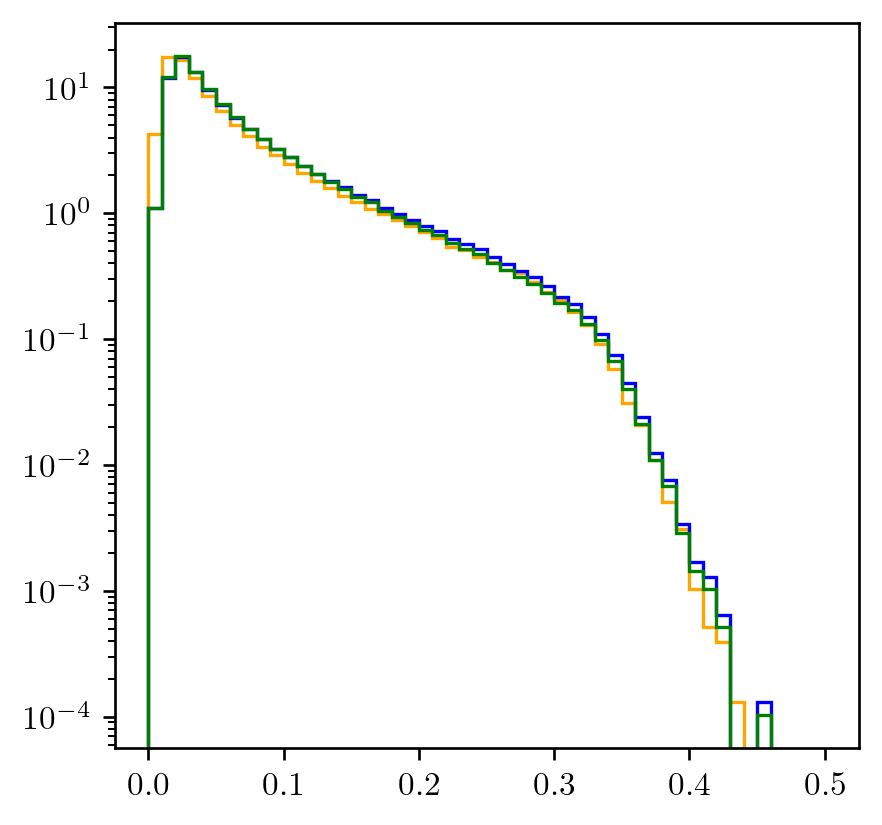

In [14]:
# compute the distributions to determine the bin-by-bin corrections
bins = np.linspace(0, 0.5, 51)
density = True

#plt.hist(nature['data_thrusts'], bins=bins, histtype='step', color='black', density=density)
simhist = plt.hist(synthetic['sim_thrusts'], bins=bins, histtype='step', color='orange', density=density)[0]
genhist = plt.hist(synthetic['gen_thrusts'], bins=bins, histtype='step', color='blue', density=density)[0]
genbhist = plt.hist(synthetic['genBefore_thrusts'], bins=bins, histtype='step', color='green', density=density)[0]

plt.yscale('log')

plt.show()

## Specifying the Unfolding Problem

In [51]:
# how many iterations of the unfolding process
itnum = 5

In [52]:
# the observables to use for multifold (a single one just indicates unifold)
obs_multifold = ['Thrust']

In [53]:
# a dictionary to hold information about the observables
obs = {}

In [54]:
# the thrust and histogram style information
obs.setdefault('Thrust', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_thrusts'],
    'nbins_det': 50, 'nbins_mc': 50,
    'yscale': 'log',
    'xlim': (0, 0.5), 'ylim': (10**-4.5, 100), 'ylim_ratio': (0.7, 1.3),
    'ytick_ratio_step': 0.15,
    'xlabel': r'Thrust $\tau$', 'symbol': r'$\tau$',
    'ylabel': r'Normalized Cross Section', 'ylabel_ratio': 'Ratio to\nALEPH',
    'stamp_xy': (0.5, 0.9),
    'legend_loc': 'lower left', 'legend_ncol': 1
})

# additional histogram and plot style information
hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': r'\textsc{Pythia} 6 Generation'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': 'ALEPH Measurement'}
ibu_style = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'gray', 'zorder': 1}
omnifold_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}

In [55]:
# calculate quantities to be stored in obs
for obkey,ob in obs.items():
    
    # calculate observable for GEN, SIM, DATA, and TRUE
    ob['genobs'], ob['simobs'] = ob['func'](synthetic, 'gen'), ob['func'](synthetic, 'sim')
    ob['dataobs'] = ob['func'](nature, 'data')
    
    # setup bins
    ob['bins_det'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]
    
    # get the histograms of GEN, DATA, and TRUTH level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'], density=True)[0]
    ob['data_hist'] = np.histogram(ob['dataobs'], bins=ob['bins_det'], density=True)[0]

    # compute (and normalize) the response matrix between GEN and SIM
    ob['response'] = np.histogram2d(ob['simobs'], ob['genobs'], bins=(ob['bins_det'], ob['bins_mc']))[0]
    ob['response'] /= (ob['response'].sum(axis=0) + 10**-50)
    
    # perform iterative Bayesian unfolding
    ob['ibu_phis'] = ibu.ibu(ob['data_hist'], ob['response'], ob['genobs_hist'], 
                             ob['binwidth_det'], ob['binwidth_mc'], it=itnum)
    ob['ibu_phi_unc'] = ibu.ibu_unc(ob, it=itnum, nresamples=25)
    
    print('Done with', obkey)

Done with Thrust


In [77]:
from pyunfold import iterative_unfold

In [120]:
data, data_err = modplot.calc_hist(ob['dataobs'], bins=ob['bins_det'], density=True)[:2]

result = iterative_unfold(data=data, data_err=data_err,
                          response=ob['response'], response_err=0.1*np.ones(ob['response'].shape),
                          efficiencies=np.ones(len(genhist)),
                          efficiencies_err=0.001*np.ones(len(genhist)),
                          prior=ob['genobs_hist']/np.sum(ob['genobs_hist']),
                          max_iter=5, return_iterations=True, ts_stopping=0)

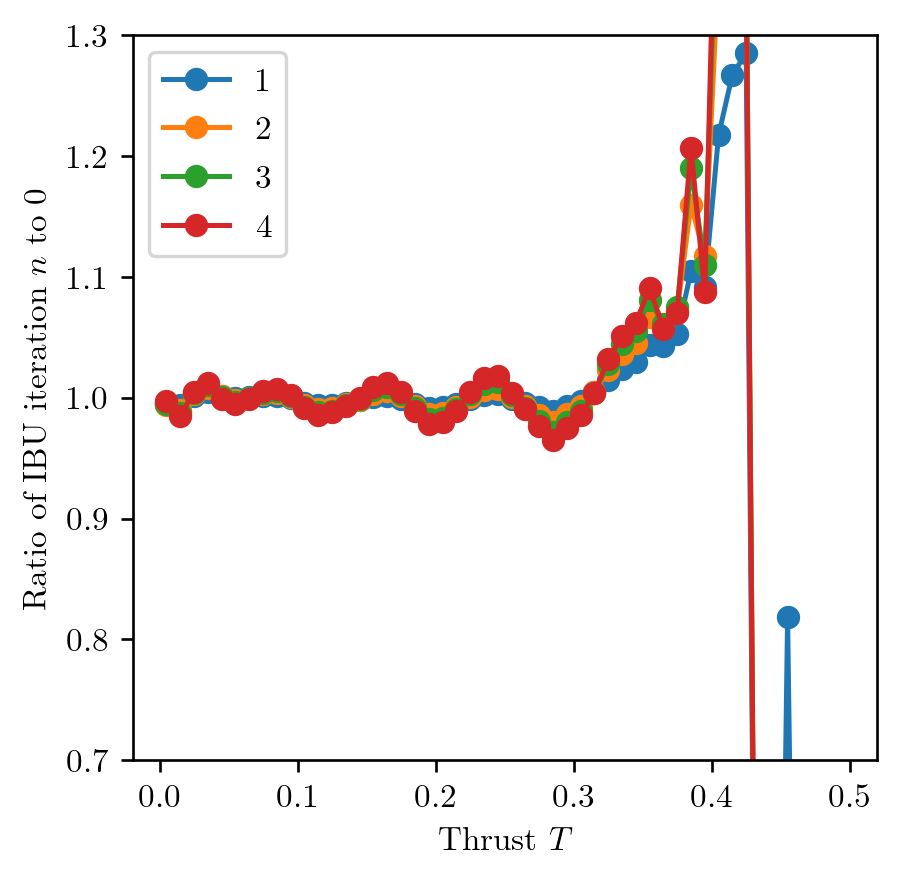

In [122]:
for i in range(1, 5):
    plt.plot(ob['midbins_det'], result['unfolded'][i]/(result['unfolded'][0] + 1e-50), 'o-', label=str(i))
plt.ylim(0.7, 1.3)
plt.xlabel('Thrust $T$')
plt.ylabel('Ratio of IBU iteration $n$ to 0')
plt.legend()
plt.show()

## OmniFold

In [10]:
from keras.optimizers import Adam

In [14]:
model_layer_sizes = [100, 100, 100]
#model_layer_sizes = [100, 100, 100] # use this for the full network size

# set up the array of data/simulation detector-level observables
ob0 = obs_multifold[0]
X_det = np.asarray([np.concatenate((obs[obkey]['dataobs'], obs[obkey]['simobs'])) for obkey in obs_multifold]).T
Y_det = ef.utils.to_categorical(np.concatenate((np.ones(len(obs[ob0]['dataobs'])), 
                                                np.zeros(len(obs[ob0]['simobs'])))))

# set up the array of generation particle-level observables
X_gen = np.asarray([np.concatenate((obs[obkey]['genobs'], obs[obkey]['genobs'])) for obkey in obs_multifold]).T
Y_gen = ef.utils.to_categorical(np.concatenate((np.ones(len(obs[ob0]['genobs'])), 
                                                np.zeros(len(obs[ob0]['genobs'])))))

# standardize the inputs
X_det = (X_det - np.mean(X_det, axis=0))/np.std(X_det, axis=0)
X_gen = (X_gen - np.mean(X_gen, axis=0))/np.std(X_gen, axis=0)

# Specify the training parameters
# model parameters for the Step 1 network
det_args = {'input_dim': len(obs_multifold), 'dense_sizes': model_layer_sizes,
            'patience': 10, 'filepath': 'ptktraining/Step1_{}', 'save_weights_only': False,
            'modelcheck_opts': {'save_best_only': True, 'verbose': 1},
            'optimizer': Adam(lr=0.0005)
           }

# model parameters for the Step 2 network
mc_args = {'input_dim': len(obs_multifold), 'dense_sizes': model_layer_sizes, 
           'patience': 10, 'filepath': 'ptktraining/Step2_{}', 'save_weights_only': False, 
           'modelcheck_opts': {'save_best_only': True, 'verbose': 1},
           'optimizer': Adam(lr=0.0005)
          }

# general training parameters
#fitargs = {'batch_size': 500, 'epochs': 2, 'verbose': 1}
fitargs = {'batch_size': 100, 'epochs': 10, 'verbose': 1} # use this for a full training

# reweight the sim and data to have the same total weight to begin with
ndata, nsim = np.count_nonzero(Y_det[:,1]), np.count_nonzero(Y_det[:,0])
wdata = np.ones(ndata)
winit = ndata/nsim*np.ones(nsim)

In [15]:
# only run this if you want to re-train the OF model. Otherwise will used the saved version
if True:

    # apply the OmniFold procedure to get weights for the generation
    multifold_ws = omnifold.omnifold(X_gen, Y_gen, X_det, Y_det, wdata, winit,
                                     (ef.archs.DNN, det_args), (ef.archs.DNN, mc_args),
                                     fitargs, val=0.2, it=itnum, trw_ind=-2,
                                     weights_filename='ptktraining/ThrustNoCuts')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_0 (Dense)              (None, 100)               200       
_________________________________________________________________
activation_8 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_9 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_10 (Activation)   (None, 100)               0         
_________________________________________________________________
output (Dense)               (None, 2)                

Epoch 8/10
1234100/1234556 [============================>.] - ETA: 0s - loss: 1.2176 - acc: 0.4998
Epoch 00008: val_loss did not improve from 1.21756
1234556/1234556 [==============================] - 12s 10us/sample - loss: 1.2176 - acc: 0.4998 - val_loss: 1.2176 - val_acc: 0.5000
Epoch 9/10
1229300/1234556 [============================>.] - ETA: 0s - loss: 1.2176 - acc: 0.4999
Epoch 00009: val_loss did not improve from 1.21756
1234556/1234556 [==============================] - 12s 10us/sample - loss: 1.2176 - acc: 0.4999 - val_loss: 1.2176 - val_acc: 0.5000
Epoch 10/10
1228500/1234556 [============================>.] - ETA: 0s - loss: 1.2176 - acc: 0.5003
Epoch 00010: val_loss did not improve from 1.21756
1234556/1234556 [==============================] - 13s 10us/sample - loss: 1.2176 - acc: 0.5003 - val_loss: 1.2176 - val_acc: 0.5000
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #

1234500/1234556 [============================>.] - ETA: 0s - loss: 1.2237 - acc: 0.4998
Epoch 00002: val_loss did not improve from 1.22368
1234556/1234556 [==============================] - 14s 11us/sample - loss: 1.2237 - acc: 0.4998 - val_loss: 1.2237 - val_acc: 0.5000
Epoch 3/10
1230500/1234556 [============================>.] - ETA: 0s - loss: 1.2237 - acc: 0.4997
Epoch 00003: val_loss did not improve from 1.22368
1234556/1234556 [==============================] - 13s 11us/sample - loss: 1.2237 - acc: 0.4997 - val_loss: 1.2237 - val_acc: 0.5000
Epoch 4/10
1232200/1234556 [============================>.] - ETA: 0s - loss: 1.2237 - acc: 0.4995
Epoch 00004: val_loss did not improve from 1.22368
1234556/1234556 [==============================] - 13s 10us/sample - loss: 1.2237 - acc: 0.4995 - val_loss: 1.2237 - val_acc: 0.5000
Epoch 5/10
1229900/1234556 [============================>.] - ETA: 0s - loss: 1.2237 - acc: 0.4999
Epoch 00005: val_loss did not improve from 1.22368
1234556/1234

## Plot Unfolding Results

In [17]:
with open('HEPData-ins636645-v1-Table_54.csv', 'r') as f:
    
    vals = []
    for row in f:
        if row.startswith('#'):
            continue
            
        if row.startswith('T'):
            print(row.strip())
        else:
            vals.append(row.strip().split(','))
            
hepdata = np.asarray(vals, dtype=float)

THRUST,THRUST LOW,THRUST HIGH,(1/SIG)*D(SIG)/DTHRUST,stat +,stat -,sys_1 +,sys_1 -,sys_2 +,sys_2 -


In [58]:
multifold_ws = np.load('ptktraining/ThrustNoCuts.npy')

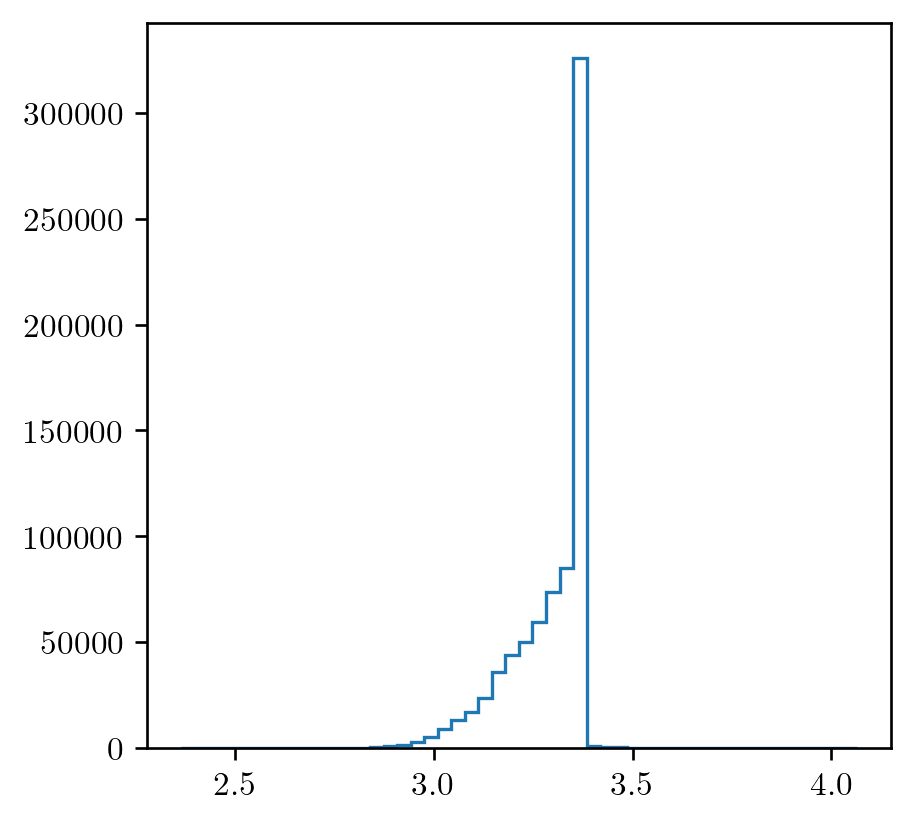

In [50]:
plt.hist(multifold_ws[3], bins=50, histtype='step')
plt.show()

In [75]:
corrs = genbhist/(genhist + 10**-50)

In [66]:
corrs = np.ones(len(genhist))

In [71]:
obs.keys()

dict_keys(['Thrust'])

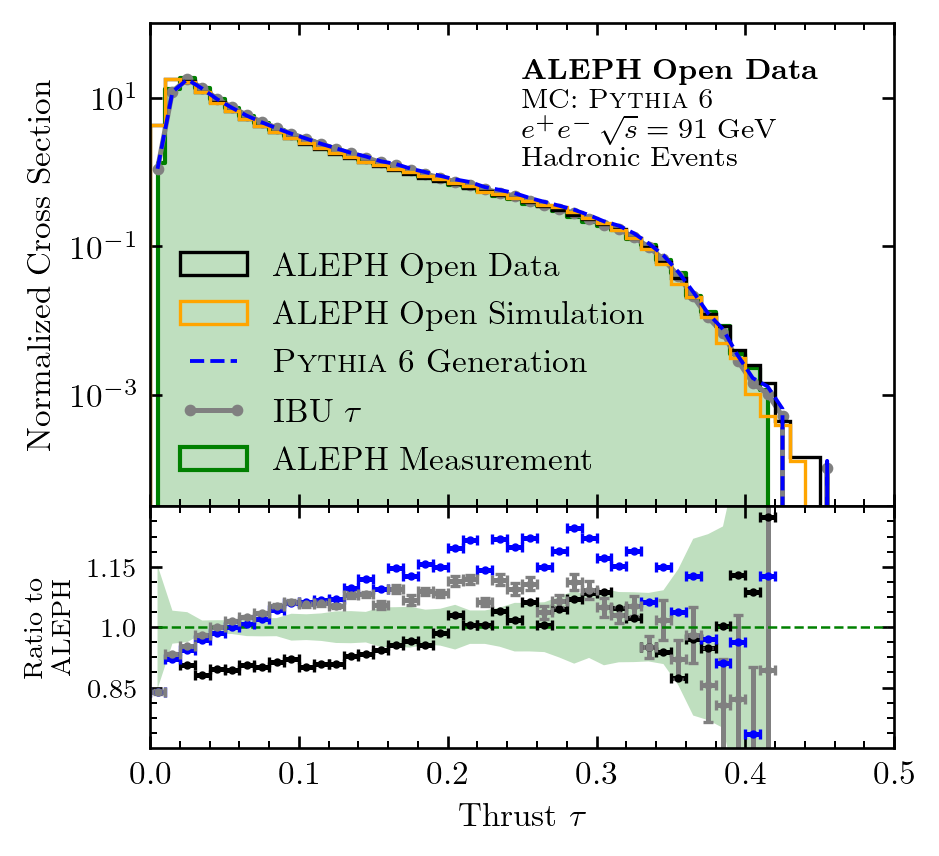

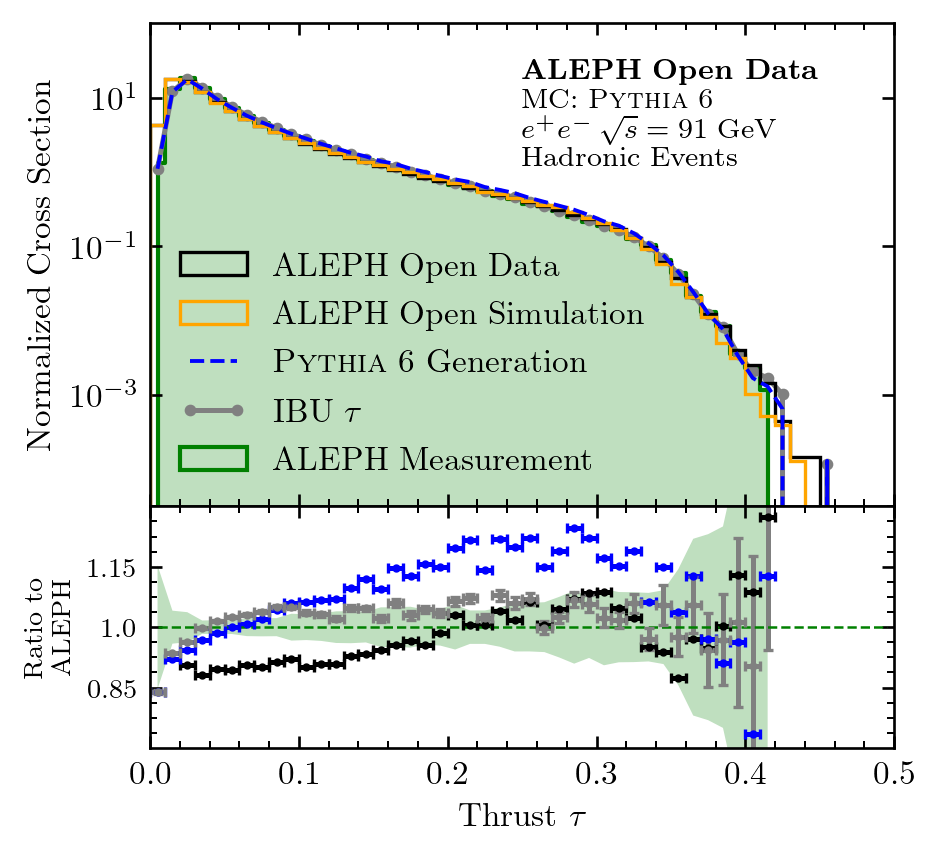

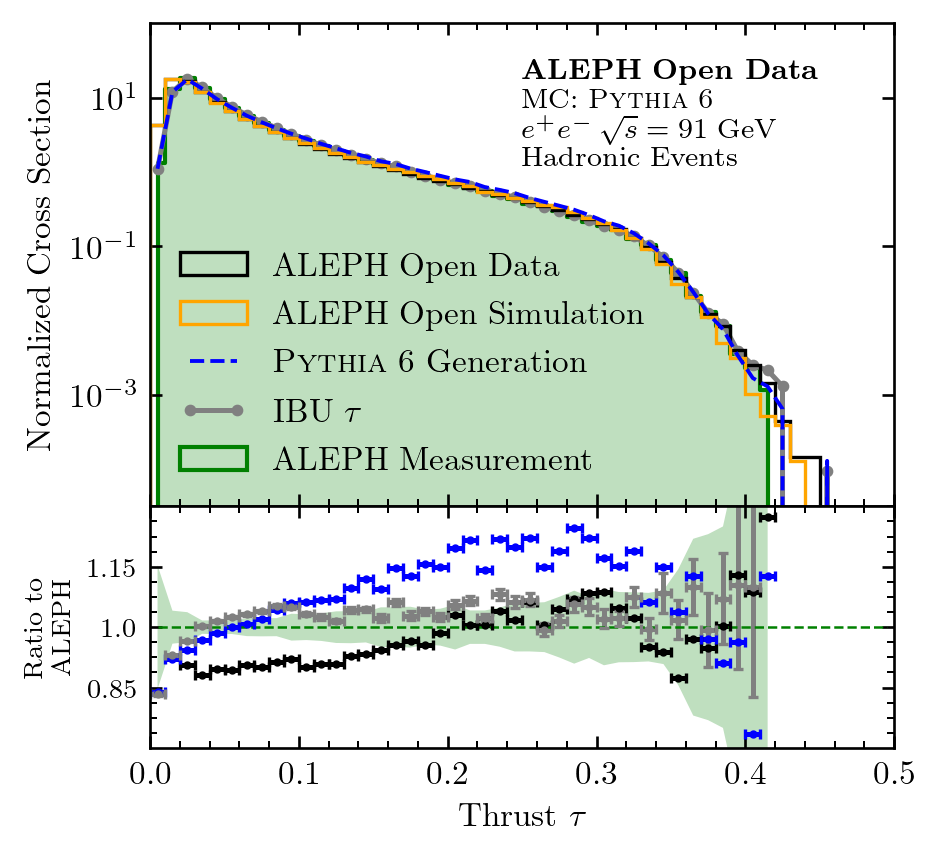

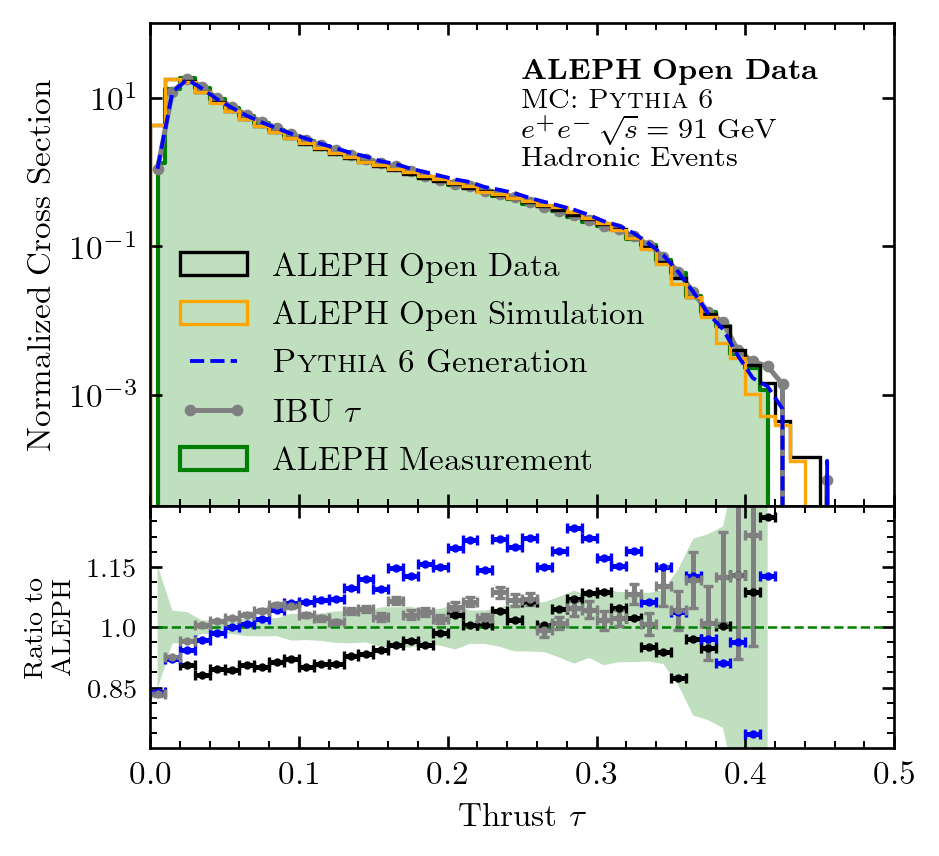

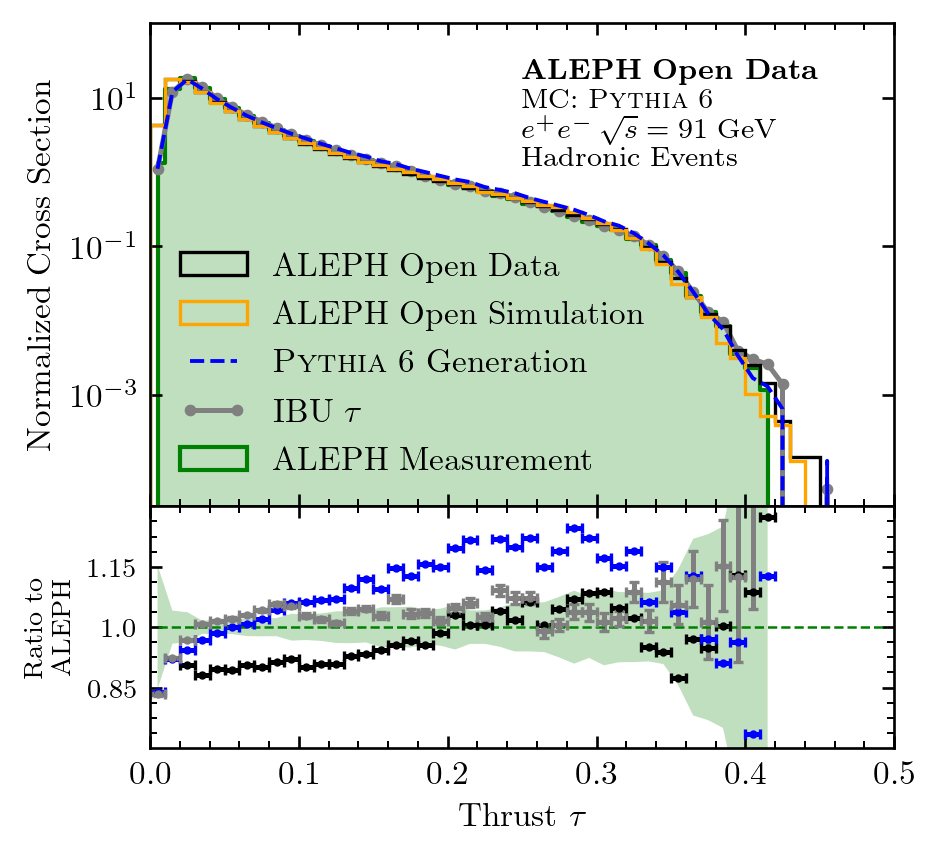

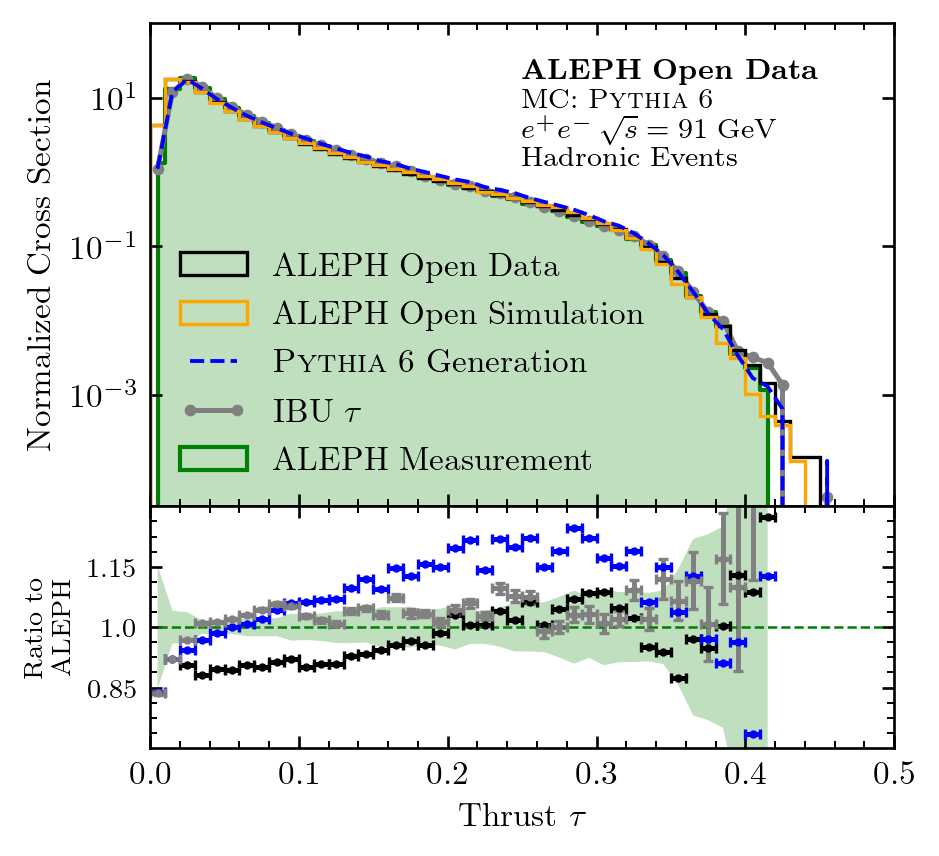

In [76]:
i = 0
obkey = 'Thrust'
ob = obs['Thrust']

for itnum in range(6):
    
    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob, gridspec_update={'height_ratios': (2, 1)})
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])

    # Plot the Different Distributions of the Observable
    # plot the "data" histogram of the observable
    ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='ALEPH Open Data', **hist_style)

    # plot the "sim" histogram of the observable
    ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='ALEPH Open Simulation', **hist_style)

    # plot the "gen" histogram of the observable
    ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)

    # plot the "truth" histogram of the observable
    #ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)
    aleph_midbins = 1 - hepdata[::-1,0]
    aleph_thrust = hepdata[::-1,3]
    aleph_errs = np.linalg.norm(hepdata[::-1,[-1,-3,-5]], axis=1)
    ax0.fill_between(aleph_midbins, aleph_thrust, **truth_style)
    
    # Plot the Unfolded Distributions of the Observable
    # plot the OmniFold distribution
    of_histgen, of_histgen_unc = modplot.calc_hist(ob['genobs'], weights=multifold_ws[-1], 
                                                   bins=ob['bins_mc'], density=True)[:2]
    of_histgen *= corrs
    of_histgen_unc *= corrs
    #ax0.plot(ob['midbins_mc'], of_histgen, **omnifold_style, label=r'UniFold $1-\tau$')

    # plot the IBU distribution
    ibu_hist = ob['ibu_phis'][itnum]*corrs
    ax0.plot(ob['midbins_mc'], ibu_hist, **ibu_style, label='IBU ' + ob['symbol'])

    # Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
    ibu_ratio = ibu_hist[:len(hepdata)]/(aleph_thrust + 10**-50)
    of_ratio = of_histgen[:len(hepdata)]/(aleph_thrust + 10**-50)
    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '--', color='green', lw=0.75)
    
    # ratio uncertainties
    aleph_unc_ratio = aleph_errs/(aleph_thrust + 10**-50)
    ibu_unc_ratio = ob['ibu_phi_unc'][:len(hepdata)]*corrs[:len(hepdata)]/(aleph_thrust + 10**-50)
    of_unc_ratio = of_histgen_unc[:len(hepdata)]/(aleph_thrust + 10**-50)
    
    # data ratio
    ax1.errorbar(aleph_midbins, ob['data_hist'][:len(hepdata)]/(aleph_thrust + 10**-50), 
                 xerr=ob['binwidth_mc']/2,
                 color='black', **modplot.style('errorbar'))
    
    ax1.errorbar(aleph_midbins, ob['genobs_hist'][:len(hepdata)]/(aleph_thrust + 10**-50), 
                 xerr=ob['binwidth_mc']/2,
                 color='blue', **modplot.style('errorbar'))
    
    ax1.fill_between(aleph_midbins, 1 - aleph_unc_ratio, 1 + aleph_unc_ratio, 
                     facecolor=truth_style['facecolor'], zorder=-2)
    ax1.errorbar(aleph_midbins, ibu_ratio, xerr=ob['binwidth_mc']/2, yerr=ibu_unc_ratio, 
                                              color=ibu_style['color'], **modplot.style('errorbar'))
    #ax1.errorbar(aleph_midbins, of_ratio, xerr=ob['binwidth_mc']/2, yerr=of_unc_ratio, 
    #                                          color=omnifold_style['color'], **modplot.style('errorbar'))

    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    order = [2, 3, 0, 1, 4]#[3, 4, 0, 5, 2, 1]
    modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
                  line_0=r'\textbf{ALEPH Open Data}',
                  line_1=r'MC: \textsc{Pythia 6}',
                  line_2=r'$e^+e^-\,\sqrt{s}=91$ GeV',
                  line_3='Hadronic Events')

    # save plot (by default in the same directory as this notebook).
    # If running on binder, the plot can be accessed by first going to the jupyter file browser
    # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
    # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
    #fig.savefig('UniFold_{}_NoCuts_tgBeforeCorrs.pdf'.format(obkey), bbox_inches='tight')
    plt.show()